### Scenario 3: Flexible Staffing
Optimize agent shifts - more agents working during "peak hours", reduced agents working during "low-volume" hours. 
Achieved by dividing the simulation into time period segments (e.g. 2hrs, 3hrs, 5hrs, 3hrs, 3hrs.) and running the modified simulate_calls() function with the appropriate number of servers each time. 

Current setup and change from default: 
Default scenario has 10 agents throughout all 16 hours of work time (6:00am-10:00pm, a.k.a. 0600-2200). 
New scenario setup as follows: 
* From 6:00-8:00, 5 agents working
* From 8:00-11:00, 10 agents working
* From 11:00-16:00, 5 agents working
* From 16:00-19:00, 10 agents working 
* From 19:00-22:00. 5 agents working

This change corresponds to the call centre allocating work hours for employee shifts by typical demand - a move intended to reduce call abandon rates and waiting times without increasing the overall resources required. 

## **Code section: Initial parameters & Function definitions** ##


In [1]:
# Basic Parameters
num_queues = 1    # single queue. UNUSED
num_calls = 800  # Number of calls to simulate
num_servers = 10  # Number of agents (servers) answering calls

## MODIFIED PARAMETERS
num_servers_s1 = 5 # hours 6:00-8:00
num_servers_s2 = 10 # hours 8:00-11:00
num_servers_s3 = 5 # hours 11:00-16:00
num_servers_s4=10 # hours 16:00-19:00
num_servers_s5 = 5 # hours 19:00-22:00

num_calls_s1 = 78
num_calls_s2 = 236
num_calls_s3 = 195
num_calls_s4 = 193
num_calls_s5 = 98

starting_time_s1 = 0 #let 6:00 be the first minute
starting_time_s2 = 120 # 8:00 is 120 minutes after 6:00
starting_time_s3 = 300 # 11:00 is 300 minutes after 6:00
starting_time_s4 = 600 # 16:00 is 600 minutes after 6:00
starting_time_s5 = 780 # 19:00 is 780 minutes after 6:00

In [2]:
# Generate inter-arrival times for all 800 calls fitted on distribution
import numpy as np
from scipy.stats import expon

# generate hourly call distribution (with low-volume and peak times)
def generate_interarrival_times(hourly_calls, minutes_per_hour=60):
    """
    Generate inter-arrival times for a given hourly call volume distribution.

    Parameters:
        hourly_calls: List[int] - Number of calls per hour (6 AM to 10 PM).
        seconds_per_hour: int - Number of seconds in an hour (default: 3600).

    Returns:
        List[float] - Inter-arrival times in seconds for all calls.
    """
    inter_arrival_times = []
    for calls in hourly_calls:
        rate = calls / minutes_per_hour if calls > 0 else 0
        if rate > 0:
            # Generate inter-arrival times for the number of calls in each hour
            times = expon(scale=1 / rate).rvs(size=calls)
            inter_arrival_times.extend(times)
    return inter_arrival_times

# Hourly call preset discrete distribution of 1000 calls over 16 hours of working time
hourly_calls = [39,39,66,85,85,39,39,39,39,39,55,69,69,39,39,20]
data_inter_arrival_times = generate_interarrival_times(hourly_calls)

# Print a few sample inter-arrival times
print("Sample Inter-Arrival Times:", data_inter_arrival_times[:10])
print("Total Number of Inter-Arrival Times Generated:", len(data_inter_arrival_times))


Sample Inter-Arrival Times: [2.1450533764977275, 2.4013346907810305, 0.5546045284498557, 2.0715964493649124, 4.101761005702738, 0.4412007546474578, 1.6315792156218958, 0.47958037075280086, 2.0664005483804475, 0.2151457550783981]
Total Number of Inter-Arrival Times Generated: 800


In [3]:
from scipy.stats import gamma

def generate_waiting_times(num_samples, alpha=1.99, beta=2.79):
    """
    Generate a list of nuum_samples random waiting times based on a gamma distribution.

    Parameters:
    - num_samples (int): Number of waiting times to generate.
    - alpha (float): Shape parameter of the gamma distribution (default is 1.99).
    - beta (float): Scale parameter of the gamma distribution (default is 2.79).

    Returns:
    - list: Randomly generated waiting times.
    """
    return gamma.rvs(a=alpha, scale=beta, size=num_samples).tolist()

# Generate array of waiting times for 1000 calls in the day
data_max_waiting_times = generate_waiting_times(num_calls)
#print(waiting_times)

# Print a few sample max waiting times
print("Sample Max. Waiting Times (in minutes):", data_max_waiting_times[:10])
print("Total Number of Max. Waiting Times Generated:", len(data_max_waiting_times))

Sample Max. Waiting Times (in minutes): [9.067165830153701, 2.1606182097034403, 3.282139091223898, 5.896891644849063, 5.591417155792816, 7.307314745257586, 6.889643626786102, 3.327386175411198, 9.669115885606088, 16.13241948286499]
Total Number of Max. Waiting Times Generated: 800


In [4]:
# Custom functions for generating service time for one call
def generate_service_time():
    return np.random.exponential(1 / 0.14)   # Service time ~ Exponential(5)

In [5]:
def simulate_calls(
    num_calls,
    starting_time,
    interarrival_times,
    max_waiting_times,
    generate_service_time,
    num_servers
):
    """
    Simulates call handling in a multi-server queue system.

    Parameters:
        num_calls (int): Number of calls to simulate.
        interarrival_times (list): List of inter-arrival times for each call.
        max_waiting_times (list): List of maximum waiting times for each call before abandonment.
        generate_service_time (function): Function to generate service times for calls.
        num_servers (int): Number of servers available.

    Returns:
        dict: Results of the simulation including arrival times, service times, waiting times,
              departure times, abandoned calls, server utilizations, etc.
    """
    # Initialize variables
    arrival_times = []
    service_times = []
    waiting_times = []
    waiting_times_with_abandon = []
    departure_times = []
    abandon_call_count = 0

    server_utilization = [0] * num_servers
    server_end_times = [0] * num_servers

    next_available_time = -1

    # Simulate calls
    for i in range(num_calls):
        # Generate arrival time; first arrival time set to 0
        if i == 0:
            arrival_time = starting_time
        else:
            interarrival_time = interarrival_times[i]
            arrival_time = arrival_times[-1] + interarrival_time

        # Generate service time (call duration)
        service_time = generate_service_time()

        # Set max. waiting time
        max_waiting_time = max_waiting_times[i]

        # Assign the earliest available server
        next_available_time = min(server_end_times)
        server_index = server_end_times.index(next_available_time)
        if arrival_time >= next_available_time:
            # No waiting, server is free
            waiting_time = 0
            start_service_time = arrival_time
        else:
            # Waiting required
            waiting_time = next_available_time - arrival_time
            # Abandon call if waiting time exceeds maximum waiting time
            if waiting_time > max_waiting_time:
                waiting_times_with_abandon.append(waiting_time)
                abandon_call_count += 1
                continue

            start_service_time = next_available_time

        # Append to lists if call not abandoned
        arrival_times.append(arrival_time)
        service_times.append(service_time)
        waiting_times.append(waiting_time)
        waiting_times_with_abandon.append(waiting_time)

        # Calculate departure time
        departure_time = start_service_time + service_time
        departure_times.append(departure_time)

        # Update server end time and utilization
        server_end_times[server_index] = departure_time
        server_utilization[server_index] += service_time

    # Return simulation results as a dictionary
    return {
        "arrival_times": arrival_times,
        "service_times": service_times,
        "waiting_times": waiting_times,
        "waiting_times_with_abandon": waiting_times_with_abandon,
        "departure_times": departure_times,
        "abandon_call_count": abandon_call_count,
        "server_utilization": server_utilization,
        "next_available_time": next_available_time,
    }


## **Code section: Main program** ##


In [6]:
# Main program
import numpy as np
import pandas as pd
from scipy.stats import expon
import copy


# Initialize variables with pre-existing data:
arrival_times = []  # List to store arrival times
service_times = []  # List to store service times
max_waiting_times = []   # List to store max waiting times before abandonning calls

# Initialize variables with values calculated from simulation
waiting_times = []  # List to store waiting times
waiting_times_with_abandon = []   # List to store waiting times including those who abandonned
waiting_times_abandon_only = []   # List to store waiting times of abandonned calls
departure_times = []  # List to store departure times
answered_call_count = 0 # Number of calls successfully picked up and answered
abandon_call_count = 0  # Number of calls abandoned due to exceeding max. waiting time

abandon_call_count_s1 = 0 # Number of calls abandoned in s1
abandon_call_count_s2 = 0 # Number of calls abandoned in s2
abandon_call_count_s3 = 0 # Number of calls abandoned in s3
abandon_call_count_s4 = 0 # Number of calls abandoned in s4
abandon_call_count_s5 = 0 # Number of calls abandoned in s5


# output model measurement (sensitivity analysis) metrics:
server_utilization = [0] * num_servers  # Track total service time handled by each server
server_end_times = [0] * num_servers    # Track when each server will be free; only used for function
### MODIFIED FOR SCENARIO: different server_utilization value for each time period


# set interarrival times of 800 calls from preset data
interarrival_times = data_inter_arrival_times
# set max. waiting times of 800 calls from preset data
max_waiting_times = data_max_waiting_times



In [7]:
# Simulate calls for segment 1: 6:00-8:00 (2hrs); first 78 calls with 5 servers

call_simulation_results1 = simulate_calls(
    num_calls_s1,
    starting_time_s1,
    interarrival_times,
    max_waiting_times,
    generate_service_time,
    num_servers_s1
)


arrival_times = np.append(arrival_times, call_simulation_results1["arrival_times"])
service_times = np.append(service_times, call_simulation_results1["service_times"])
waiting_times = np.append(waiting_times, call_simulation_results1["waiting_times"])
waiting_times_with_abandon = np.append(waiting_times_with_abandon,
                                            call_simulation_results1["waiting_times_with_abandon"])
departure_times = np.append(departure_times, call_simulation_results1["departure_times"])

# Record total simulation time for s1 calls
total_simulation_time_s1 = max(departure_times)

abandon_call_count += call_simulation_results1["abandon_call_count"]
abandon_call_count_s1 += call_simulation_results1["abandon_call_count"]
server_utilization_s1 = call_simulation_results1["server_utilization"]


In [8]:
# Simulate calls for segment 2: 8:00-11:00 (3hrs); first 236 calls with 10 servers

# update starting time from the immediate next_available_time from end of s1 simulation
starting_time_s2 = call_simulation_results1["next_available_time"]

call_simulation_results2 = simulate_calls(
    num_calls_s2,
    starting_time_s2,
    interarrival_times[78:],
    max_waiting_times[78:],
    generate_service_time,
    num_servers_s2
)


arrival_times = np.append(arrival_times, call_simulation_results2["arrival_times"])
service_times = np.append(service_times, call_simulation_results2["service_times"])
waiting_times = np.append(waiting_times, call_simulation_results2["waiting_times"])
waiting_times_with_abandon = np.append(waiting_times_with_abandon,
                                            call_simulation_results2["waiting_times_with_abandon"])
departure_times = np.append(departure_times, call_simulation_results2["departure_times"])

# Record total simulation time for s2 calls
total_simulation_time_s2 = max(departure_times) - total_simulation_time_s1

abandon_call_count += call_simulation_results2["abandon_call_count"]
abandon_call_count_s2 += call_simulation_results2["abandon_call_count"]

server_utilization_s2 = call_simulation_results2["server_utilization"]


In [9]:
# Simulate calls for segment 3: 11:00-16:00(5hrs); first 195 calls with 5 servers

# update starting time from the immediate next_available_time from end of s2 simulation
starting_time_s3 = call_simulation_results2["next_available_time"]

call_simulation_results3 = simulate_calls(
    num_calls_s3,
    starting_time_s3,
    interarrival_times[314:],
    max_waiting_times[314:],
    generate_service_time,
    num_servers_s3
)


arrival_times = np.append(arrival_times, call_simulation_results3["arrival_times"])
service_times = np.append(service_times, call_simulation_results3["service_times"])
waiting_times = np.append(waiting_times, call_simulation_results3["waiting_times"])
waiting_times_with_abandon = np.append(waiting_times_with_abandon,
                                            call_simulation_results3["waiting_times_with_abandon"])
departure_times = np.append(departure_times, call_simulation_results3["departure_times"])

# Record total simulation time for s3 calls
total_simulation_time_s3 = max(departure_times) - total_simulation_time_s2

abandon_call_count += call_simulation_results3["abandon_call_count"]
abandon_call_count_s3 += call_simulation_results3["abandon_call_count"]
server_utilization_s3 = call_simulation_results3["server_utilization"]


In [10]:
# Simulate calls for segment 4: 16:00-19:00(3hrs); first 193 calls with 10 servers

# update starting time from the immediate next_available_time from end of s3 simulation
starting_time_s4 = call_simulation_results3["next_available_time"]

call_simulation_results4 = simulate_calls(
    num_calls_s4,
    starting_time_s4,
    interarrival_times[509:],
    max_waiting_times[509:],
    generate_service_time,
    num_servers_s4
)


arrival_times = np.append(arrival_times, call_simulation_results4["arrival_times"])
service_times = np.append(service_times, call_simulation_results4["service_times"])
waiting_times = np.append(waiting_times, call_simulation_results4["waiting_times"])
waiting_times_with_abandon = np.append(waiting_times_with_abandon,
                                            call_simulation_results4["waiting_times_with_abandon"])
departure_times = np.append(departure_times, call_simulation_results4["departure_times"])

# Record total simulation time for s4 calls
total_simulation_time_s4 = max(departure_times) - total_simulation_time_s3

abandon_call_count += call_simulation_results4["abandon_call_count"]
abandon_call_count_s4 += call_simulation_results4["abandon_call_count"]
server_utilization_s4 = call_simulation_results4["server_utilization"]

In [11]:
# Simulate calls for segment 5: 19:00-22:00(3hrs); first 98 calls with 5 servers

# update starting time from the immediate next_available_time from end of s4 simulation
starting_time_s5 = call_simulation_results4["next_available_time"]

call_simulation_results5 = simulate_calls(
    num_calls_s5,
    starting_time_s5,
    interarrival_times[702:],
    max_waiting_times[702:],
    generate_service_time,
    num_servers_s5
)


arrival_times = np.append(arrival_times, call_simulation_results5["arrival_times"])
service_times = np.append(service_times, call_simulation_results5["service_times"])
waiting_times = np.append(waiting_times, call_simulation_results5["waiting_times"])
waiting_times_with_abandon = np.append(waiting_times_with_abandon,
                                            call_simulation_results5["waiting_times_with_abandon"])
departure_times = np.append(departure_times, call_simulation_results5["departure_times"])

# Record total simulation time for s5 calls
total_simulation_time_s5 = max(departure_times) - total_simulation_time_s4

abandon_call_count += call_simulation_results5["abandon_call_count"]
abandon_call_count_s5 += call_simulation_results5["abandon_call_count"]
server_utilization_s5 = call_simulation_results5["server_utilization"]

In [12]:
# Calculate total number of calls answered
answered_call_count = num_calls - abandon_call_count

# Calculate total number of calls answered
answered_call_count_s1 = num_calls_s1 - abandon_call_count_s1

# Calculate total number of calls answered
answered_call_count_s2 = num_calls_s2 - abandon_call_count_s2

# Calculate total number of calls answered
answered_call_count_s3 = num_calls_s3 - abandon_call_count_s3
answered_call_count_s4 = num_calls_s4 - abandon_call_count_s4
answered_call_count_s5 = num_calls_s5 - abandon_call_count_s5

# Calculate total simulation time
total_simulation_time = max(departure_times)


# Calculate utilization rates for each server in s1
server_utilization_rates_s1 = [
    (util / total_simulation_time_s1) * 100 for util in server_utilization_s1
]

# Calculate utilization rates for each server in s2
server_utilization_rates_s2 = [
    (util / total_simulation_time_s2) * 100 for util in server_utilization_s2
]

# Calculate utilization rates for each server in s3
server_utilization_rates_s3 = [
    (util / total_simulation_time_s3) * 100 for util in server_utilization_s3
]

server_utilization_rates_s4 = [
    (util / total_simulation_time_s4) * 100 for util in server_utilization_s4
]

server_utilization_rates_s5 = [
    (util / total_simulation_time_s5) * 100 for util in server_utilization_s5
]


# Calculate overall utilization rate for each server for all time
sur_s1_weighted = [util * (num_calls_s1 / num_calls) for util in server_utilization_rates_s1]  # weighted 78/800
sur_s2_weighted = [util * (num_calls_s2 / num_calls) for util in server_utilization_rates_s2]  # 236/800
sur_s3_weighted = [util * (num_calls_s3 / num_calls) for util in server_utilization_rates_s3]  # 195/800
sur_s4_weighted = [util * (num_calls_s4 / num_calls) for util in server_utilization_rates_s4]  # 193/800
sur_s5_weighted = [util * (num_calls_s5 / num_calls) for util in server_utilization_rates_s5]  # 98/800

avg_server_utilization_rates_overall = (sum(sur_s1_weighted) / num_servers_s1
                                    + sum(sur_s2_weighted) / num_servers_s2
                                    + sum(sur_s3_weighted) / num_servers_s3
                                    + sum(sur_s4_weighted) / num_servers_s4
                                    + sum(sur_s5_weighted) / num_servers_s5) 

print(f" average of all servers utilization rate:  {avg_server_utilization_rates_overall}")
print(f" weighted average of all servers utilization rate by segment 1:  {sur_s1_weighted}")
print(f" weighted average of all servers utilization rate by segment 2:  {sur_s2_weighted}")
print(f" weighted average of all servers utilization rate by segment 3:  {sur_s3_weighted}")
print(f" weighted average of all servers utilization rate by segment 4:  {sur_s4_weighted}")
print(f" weighted average of all servers utilization rate by segment 5:  {sur_s5_weighted}")

 average of all servers utilization rate:  54.94245378316837
 weighted average of all servers utilization rate by segment 1:  [6.900950905425967, 6.626894050625503, 7.56878500907539, 6.480340318111002, 5.672061416879376]
 weighted average of all servers utilization rate by segment 2:  [24.759471355584655, 27.225035665867335, 24.24591278290831, 25.990332886910906, 23.797761140453293, 24.705324724137455, 22.33684154372317, 21.465537284032667, 19.36565412087968, 23.337285356452888]
 weighted average of all servers utilization rate by segment 3:  [14.754833557622334, 13.233763888244022, 13.021430234217881, 14.606612447639622, 12.342309711708621]
 weighted average of all servers utilization rate by segment 4:  [8.836181788441511, 8.720243228288883, 8.838434171410478, 9.257490905883815, 9.111740112101103, 7.976200319476157, 9.267803997571955, 10.008003079062451, 9.643202098574791, 8.87147950902056]
 weighted average of all servers utilization rate by segment 5:  [1.6874837155322153, 1.695051

## **Code section: Output & Model metrics** ##



In [13]:
# Create a DataFrame to display results
answered_call_count = len(service_times)  # Update to ensure consistency
df = pd.DataFrame({
    #"Call": range(1, num_calls + 1),
    "Call": range(1, answered_call_count + 1),
    "Arrival Time (min)": arrival_times,
    "Waiting Time (min)": waiting_times,
    "Service Time (min)": service_times,
    "Departure Time (min)": departure_times,
})

# Display the results
print("Call Data:")
print(df)
# print(df.head(20))

'''
# Display server utilization rates
print("\nS1 Server Utilization Rates:")
for i, rate in enumerate(server_utilization_rates_s1):
    print(f"Server {i + 1}: {rate:.2f}%")

print("\nS2 Server Utilization Rates:")
for i, rate in enumerate(server_utilization_rates_s2):
    print(f"Server {i + 1}: {rate:.2f}%")

print("\nS3 Server Utilization Rates:")
for i, rate in enumerate(server_utilization_rates_s3):
    print(f"Server {i + 1}: {rate:.2f}%")

print("\nS4 Server Utilization Rates:")
for i, rate in enumerate(server_utilization_rates_s4):
    print(f"Server {i + 1}: {rate:.2f}%")

print("\nS5 Server Utilization Rates:")
for i, rate in enumerate(server_utilization_rates_s5):
    print(f"Server {i + 1}: {rate:.2f}%")
'''



Call Data:
     Call  Arrival Time (min)  Waiting Time (min)  Service Time (min)  \
0       1            0.000000                 0.0            2.191083   
1       2            2.401335                 0.0            7.778070   
2       3            2.955939                 0.0            9.318094   
3       4            5.027536                 0.0            1.032674   
4       5            9.129297                 0.0            3.456531   
..    ...                 ...                 ...                 ...   
598   599          783.761889                 0.0           17.082787   
599   600          784.129943                 0.0            0.314329   
600   601          784.342660                 0.0            8.327646   
601   602          788.446122                 0.0            4.944557   
602   603          796.592238                 0.0            4.254447   

     Departure Time (min)  
0                2.191083  
1               10.179404  
2               12.274034  


'\n# Display server utilization rates\nprint("\nS1 Server Utilization Rates:")\nfor i, rate in enumerate(server_utilization_rates_s1):\n    print(f"Server {i + 1}: {rate:.2f}%")\n\nprint("\nS2 Server Utilization Rates:")\nfor i, rate in enumerate(server_utilization_rates_s2):\n    print(f"Server {i + 1}: {rate:.2f}%")\n\nprint("\nS3 Server Utilization Rates:")\nfor i, rate in enumerate(server_utilization_rates_s3):\n    print(f"Server {i + 1}: {rate:.2f}%")\n\nprint("\nS4 Server Utilization Rates:")\nfor i, rate in enumerate(server_utilization_rates_s4):\n    print(f"Server {i + 1}: {rate:.2f}%")\n\nprint("\nS5 Server Utilization Rates:")\nfor i, rate in enumerate(server_utilization_rates_s5):\n    print(f"Server {i + 1}: {rate:.2f}%")\n'

In [14]:
df.to_csv('call_data_scenario3.csv', index=False)

In [15]:
# Metrics Calculation

# Average waiting time (including abandoned calls)
average_waiting_time_including_abandon = (
    sum(waiting_times_with_abandon) / len(waiting_times_with_abandon)
    if waiting_times_with_abandon.size > 0 else 0
)

# Average waiting time (excluding abandoned calls)
average_waiting_time_excluding_abandon = (
    sum(waiting_times) / len(waiting_times) if waiting_times.size > 0 else 0
)

# Average server utilization
average_server_utilization_s1 = sum(server_utilization_rates_s1) / num_servers_s1
average_server_utilization_s2 = sum(server_utilization_rates_s2) / num_servers_s2
average_server_utilization_s3 = sum(server_utilization_rates_s3) / num_servers_s3
average_server_utilization_s4 = sum(server_utilization_rates_s4) / num_servers_s4
average_server_utilization_s5 = sum(server_utilization_rates_s5) / num_servers_s5
average_server_utilization = (average_server_utilization_s1 * num_calls_s1 / num_calls
                              + average_server_utilization_s2 * num_calls_s2 / num_calls
                              + average_server_utilization_s3 * num_calls_s3 / num_calls
                              + average_server_utilization_s4 * num_calls_s4 / num_calls
                              + average_server_utilization_s5 * num_calls_s4 / num_calls)

# Abandoned calls
abandoned_calls = abandon_call_count

# Abandoned calls rate
abandoned_calls_rate = (abandon_call_count / num_calls) * 100

# Abandoned calls
abandoned_calls_s1 = abandon_call_count_s1
# Abandoned calls
abandoned_calls_s2 = abandon_call_count_s2
# Abandoned calls
abandoned_calls_s3 = abandon_call_count_s3
abandoned_calls_s4 = abandon_call_count_s4
abandoned_calls_s5 = abandon_call_count_s5

# Abandoned calls rate
abandoned_calls_rate_s1 = (abandon_call_count_s1 / num_calls_s1) * 100
# Abandoned calls rate
abandoned_calls_rate_s2 = (abandon_call_count_s2 / num_calls_s2) * 100
# Abandoned calls rate
abandoned_calls_rate_s3 = (abandon_call_count_s3 / num_calls_s3) * 100
abandoned_calls_rate_s4 = (abandon_call_count_s4 / num_calls_s5) * 100
abandoned_calls_rate_s5 = (abandon_call_count_s4 / num_calls_s5) * 100

# Display Metrics
print("Simulation Metrics:")
print(f"1. Average Waiting Time (Including Abandoned Calls): {average_waiting_time_including_abandon:.2f} minutes")
print(f"2. Average Waiting Time (Excluding Abandoned Calls): {average_waiting_time_excluding_abandon:.2f} minutes")

print(f"3. Time-Average Server Utilization: {average_server_utilization:.2f}%")
print(f" 3a. Average Server Utilization from 6:00-8:00: {average_server_utilization_s1:.2f}%")
print(f" 3b. Average Server Utilization from 8:00-11:00: {average_server_utilization_s2:.2f}%")
print(f" 3c. Average Server Utilization from 11:00-16:00: {average_server_utilization_s3:.2f}%")
print(f" 3d. Average Server Utilization from 16:00-19:00: {average_server_utilization_s4:.2f}%")
print(f" 3e. Average Server Utilization from 19:00-22:00: {average_server_utilization_s5:.2f}%")

print(f"4. Number of Abandoned Calls: {abandoned_calls}")
print(f" 4a. Number of Abandoned Calls from 6:00-8:00: {abandoned_calls_s1}")
print(f" 4b. Number of Abandoned Calls from 8:00-11:00: {abandoned_calls_s2}")
print(f" 4c. Number of Abandoned Calls from 11:00-16:00: {abandoned_calls_s3}")
print(f" 4d. Number of Abandoned Calls from 16:00-19:00: {abandoned_calls_s4}")
print(f" 4e. Number of Abandoned Calls from 19:00-22:00: {abandoned_calls_s5}")


print(f"5. Abandoned Calls Rate: {abandoned_calls_rate:.2f}%")
print(f" 5a. Abandoned Calls Rate from 6:00-8:00: {abandoned_calls_rate_s1:.2f}%")
print(f" 5b. Abandoned Calls Rate from 8:00-11:00: {abandoned_calls_rate_s2:.2f}%")
print(f" 5c. Abandoned Calls Rate from 11:00-16:00: {abandoned_calls_rate_s3:.2f}%")
print(f" 5d. Abandoned Calls Rate from 16:00-19:00: {abandoned_calls_rate_s4:.2f}%")
print(f" 5e. Abandoned Calls Rate from 19:00-22:00: {abandoned_calls_rate_s5:.2f}%")




Simulation Metrics:
1. Average Waiting Time (Including Abandoned Calls): 2.73 minutes
2. Average Waiting Time (Excluding Abandoned Calls): 0.82 minutes
3. Time-Average Server Utilization: 56.81%
 3a. Average Server Utilization from 6:00-8:00: 68.20%
 3b. Average Server Utilization from 8:00-11:00: 80.42%
 3c. Average Server Utilization from 11:00-16:00: 55.76%
 3d. Average Server Utilization from 16:00-19:00: 37.53%
 3e. Average Server Utilization from 19:00-22:00: 15.71%
4. Number of Abandoned Calls: 197
 4a. Number of Abandoned Calls from 6:00-8:00: 15
 4b. Number of Abandoned Calls from 8:00-11:00: 82
 4c. Number of Abandoned Calls from 11:00-16:00: 44
 4d. Number of Abandoned Calls from 16:00-19:00: 5
 4e. Number of Abandoned Calls from 19:00-22:00: 51
5. Abandoned Calls Rate: 24.62%
 5a. Abandoned Calls Rate from 6:00-8:00: 19.23%
 5b. Abandoned Calls Rate from 8:00-11:00: 34.75%
 5c. Abandoned Calls Rate from 11:00-16:00: 22.56%
 5d. Abandoned Calls Rate from 16:00-19:00: 5.10%
 

### Graphs Section




/opt/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


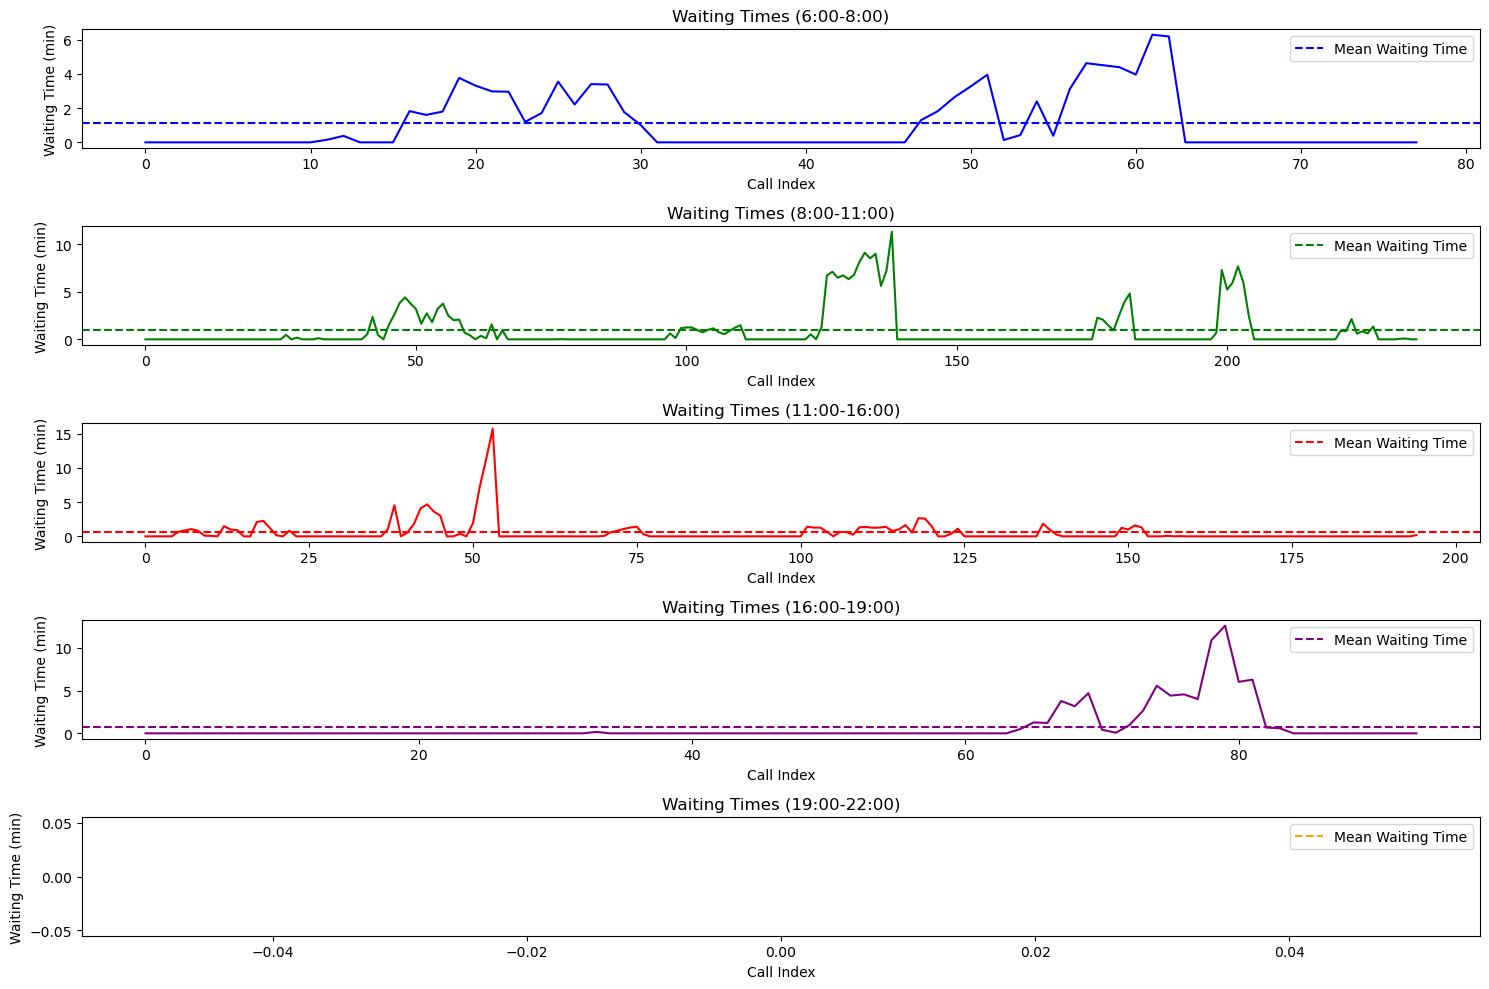

In [16]:
import matplotlib.pyplot as plt

# Data for the graphs
segments = ['6:00-8:00', '8:00-11:00', '11:00-16:00', '16:00-19:00', '19:00-22:00']
waiting_times_s1 = waiting_times[:num_calls_s1]
waiting_times_s2 = waiting_times[num_calls_s1:num_calls_s1 + num_calls_s2]
waiting_times_s3 = waiting_times[num_calls_s1 + num_calls_s2:num_calls_s1 + num_calls_s2 + num_calls_s3]
waiting_times_s4 = waiting_times[num_calls_s1 + num_calls_s2 + num_calls_s3:num_calls_s1 + num_calls_s2 + num_calls_s3 + num_calls_s4]
waiting_times_s5 = waiting_times[num_calls_s1 + num_calls_s2 + num_calls_s3 + num_calls_s4:]

# Plotting waiting times for each segment
plt.figure(figsize=(15, 10))

plt.subplot(5, 1, 1)
plt.plot(waiting_times_s1, color='blue')
plt.axhline(y=np.mean(waiting_times_s1), color='blue', linestyle='--', label='Mean Waiting Time')
plt.xlabel('Call Index')
plt.ylabel('Waiting Time (min)')
plt.title('Waiting Times (6:00-8:00)')
plt.legend()

plt.subplot(5, 1, 2)
plt.plot(waiting_times_s2, color='green')
plt.axhline(y=np.mean(waiting_times_s2), color='green', linestyle='--', label='Mean Waiting Time')
plt.xlabel('Call Index')
plt.ylabel('Waiting Time (min)')
plt.title('Waiting Times (8:00-11:00)')
plt.legend()

plt.subplot(5, 1, 3)
plt.plot(waiting_times_s3, color='red')
plt.axhline(y=np.mean(waiting_times_s3), color='red', linestyle='--', label='Mean Waiting Time')
plt.xlabel('Call Index')
plt.ylabel('Waiting Time (min)')
plt.title('Waiting Times (11:00-16:00)')
plt.legend()

plt.subplot(5, 1, 4)
plt.plot(waiting_times_s4, color='purple')
plt.axhline(y=np.mean(waiting_times_s4), color='purple', linestyle='--', label='Mean Waiting Time')
plt.xlabel('Call Index')
plt.ylabel('Waiting Time (min)')
plt.title('Waiting Times (16:00-19:00)')
plt.legend()

plt.subplot(5, 1, 5)
plt.plot(waiting_times_s5, color='orange')
plt.axhline(y=np.mean(waiting_times_s5), color='orange', linestyle='--', label='Mean Waiting Time')
plt.xlabel('Call Index')
plt.ylabel('Waiting Time (min)')
plt.title('Waiting Times (19:00-22:00)')
plt.legend()

plt.tight_layout()
plt.show()

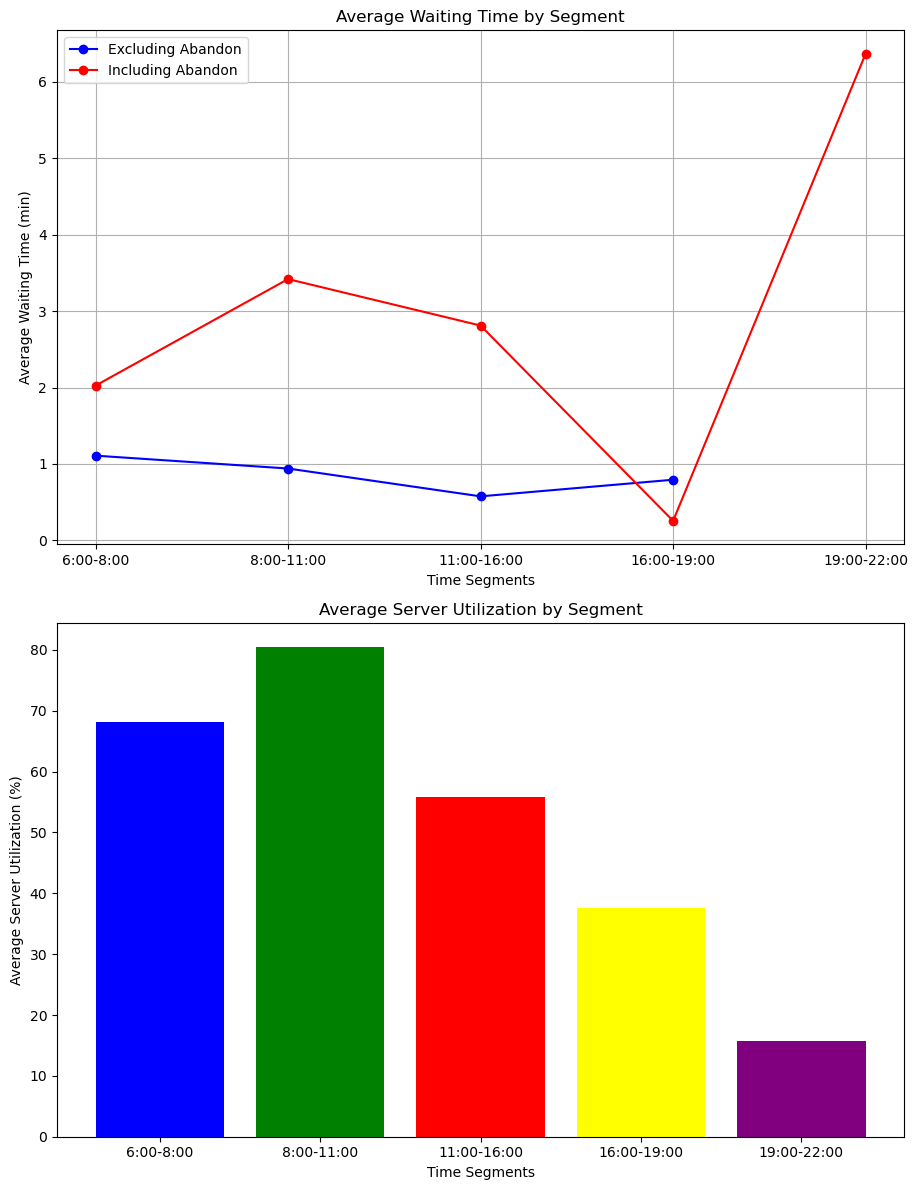

In [17]:
import numpy as np

import matplotlib.pyplot as plt

# Data for the graphs
segments = ['6:00-8:00', '8:00-11:00', '11:00-16:00', '16:00-19:00', '19:00-22:00']
average_waiting_times_excluding_abandon = [
    np.mean(waiting_times_s1),
    np.mean(waiting_times_s2),
    np.mean(waiting_times_s3),
    np.mean(waiting_times_s4),
    np.mean(waiting_times_s5)
]
average_waiting_times_including_abandon = [
    np.mean(waiting_times_with_abandon[:num_calls_s1]),
    np.mean(waiting_times_with_abandon[num_calls_s1:num_calls_s1 + num_calls_s2]),
    np.mean(waiting_times_with_abandon[num_calls_s1 + num_calls_s2:num_calls_s1 + num_calls_s2 + num_calls_s3]),
    np.mean(waiting_times_with_abandon[num_calls_s1 + num_calls_s2 + num_calls_s3:num_calls_s1 + num_calls_s2 + num_calls_s3 + num_calls_s4]),
    np.mean(waiting_times_with_abandon[num_calls_s1 + num_calls_s2 + num_calls_s3 + num_calls_s4:])
]
abandoned_calls = [
    abandon_call_count_s1,
    abandon_call_count_s2,
    abandon_call_count_s3,
    abandon_call_count_s4,
    abandon_call_count_s5
]
server_utilization_rates = [
    average_server_utilization_s1,
    average_server_utilization_s2,
    average_server_utilization_s3,
    average_server_utilization_s4,
    average_server_utilization_s5
]

# Plotting the graphs
plt.figure(figsize=(18, 12))

# Average Waiting Time (Excluding and Including Abandoned Calls) by Segment
plt.subplot(2, 2, 1)
plt.plot(segments, average_waiting_times_excluding_abandon, marker='o', color='blue', label='Excluding Abandon')
plt.plot(segments, average_waiting_times_including_abandon, marker='o', color='red', label='Including Abandon')
plt.xlabel('Time Segments')
plt.ylabel('Average Waiting Time (min)')
plt.title('Average Waiting Time by Segment')
plt.legend()
plt.grid(True)



# Average Server Utilization by Segment
plt.subplot(2, 2, 3)
plt.bar(segments, server_utilization_rates, color=['blue', 'green', 'red', 'yellow', 'purple'])
plt.xlabel('Time Segments')
plt.ylabel('Average Server Utilization (%)')
plt.title('Average Server Utilization by Segment')


plt.tight_layout()
plt.show()

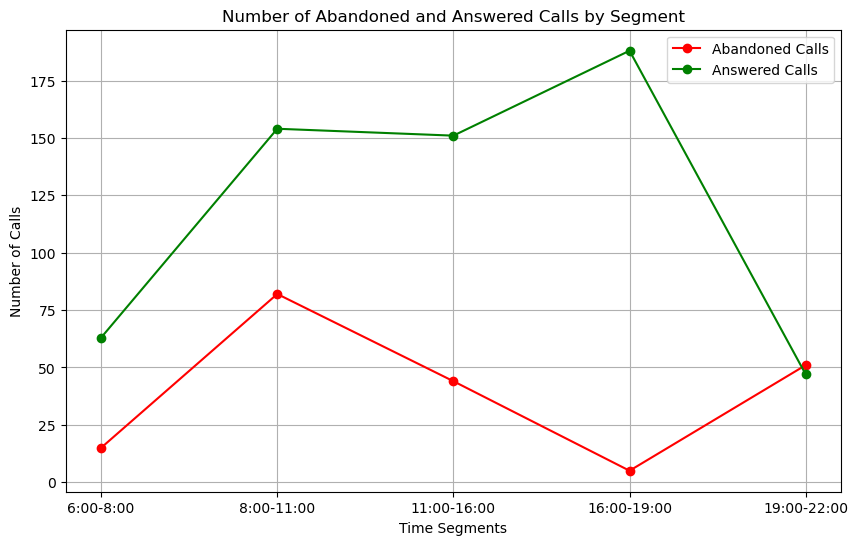

In [18]:
import matplotlib.pyplot as plt

# Data for the graphs
segments = ['6:00-8:00', '8:00-11:00', '11:00-16:00', '16:00-19:00', '19:00-22:00']
abandoned_calls = [abandon_call_count_s1, abandon_call_count_s2, abandon_call_count_s3, abandon_call_count_s4, abandon_call_count_s5]
answered_calls = [answered_call_count_s1, answered_call_count_s2, answered_call_count_s3, answered_call_count_s4, answered_call_count_s5]

# Plotting the line chart
plt.figure(figsize=(10, 6))

plt.plot(segments, abandoned_calls, marker='o', color='red', label='Abandoned Calls')
plt.plot(segments, answered_calls, marker='o', color='green', label='Answered Calls')

plt.xlabel('Time Segments')
plt.ylabel('Number of Calls')
plt.title('Number of Abandoned and Answered Calls by Segment')
plt.legend()
plt.grid(True)

plt.show()